# NLP with Disaster Tweets

## 1. Introduction

The goal of this project is to build a model that can figure out if a tweet is about a real disaster or not. Originally, I started with a pretty basic LSTM model trained from scratch. It kind of ran fine, but it got stuck around 57% accuracy, which is barely better than random guessing. Also, when I looked at precision and recall, the model basically predicted everything as "not disaster" and never found any actual disaster tweets,  
which isn’t really useful if you actually want to find important stuff during a real disaster.  

Because of that, I decided to improve a few things:
- Clean up the text data better (like removing URLs)
- Pretrain GloVe embeddings, so the model already has some understanding of word meanings
- Instead of using an LSTM, I built a simple 1D Convolutional Neural Network (CNN) model, which tends to work better for short texts like tweets 

Let's see if these changes help the model actually learn something useful.

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

np.random.seed(123)
tf.random.set_seed(123)

## 2. Data

The dataset has tweets and a label for each one (1 = disaster, 0 = not disaster). We’ll only use the `text` column as other columns like `keyword` and `location` have a lot of missing values and aren't needed for this project.

In [20]:
data = pd.read_csv('./data/train.csv')
print("Dataset shape:", data.shape)
data.head()

Dataset shape: (7613, 5)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


## 3. Exploratory Data Analysis (EDA)

First, I checked the balance between disaster and non-disaster tweets. It’s a little imbalanced (more non-disaster tweets) but not crazy. Also, I looked at a few example tweets to see what the text looks like. Some tweets have weird spellings, hashtags, and links.

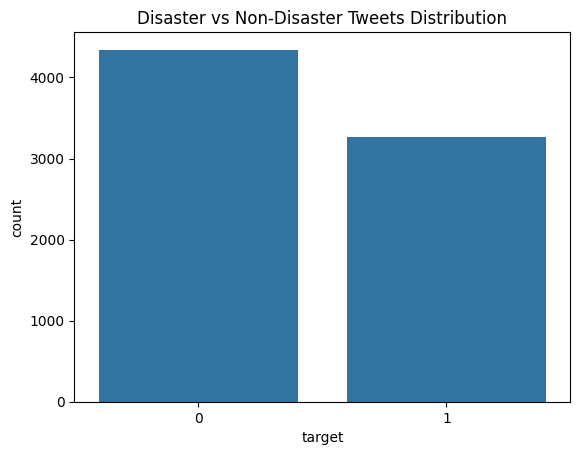

Tweet 1: Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
Tweet 2: Forest fire near La Ronge Sask. Canada
Tweet 3: All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
Tweet 4: 13,000 people receive #wildfires evacuation orders in California 
Tweet 5: Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school 


In [21]:
# class distribution
sns.countplot(x='target', data=data)
plt.title('Disaster vs Non-Disaster Tweets Distribution')
plt.show()

# some sample tweets
for idx in range(5):
    print(f"Tweet {idx+1}: {data['text'].iloc[idx]}")

## 4. Cleaning and Preprocessing the Tweets

Since tweets are messy, I did some basic cleaning:
- Made everything lowercase
- Got rid of punctuation and special characters
- Removed URLs because a lot of tweets have links that aren't useful for classification

There’s definitely fancier stuff you could do (like removing stopwords, lemmatization, etc.), but for now I'm keeping it simple. After cleaning, I tokenized the tweets, turned them into sequences of numbers, and padded them so they all have the same length. Neural nets need input of the same size in each batch, so padding is necessary.

In [22]:
# basic text cleaning
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)  # remove links
    text = re.sub(r'[^a-z0-9\s]', '', text)
    return text

data['text_clean'] = data['text'].apply(clean_text)

# tokenizer
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(data['text_clean'])

# convert to sequences
sequences = tokenizer.texts_to_sequences(data['text_clean'])
padded_sequences = pad_sequences(sequences, maxlen=100, padding='post', truncating='post')

# labels and features
X = padded_sequences
y = data['target'].values

# split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 5. Initial Model Architecture

Since tweets are short sequences, I initially decided to use an LSTM model. LSTM (Long Short-Term Memory) networks are good for remembering important information from earlier words in a sequence.  

Instead of doing TF-IDF (which just counts word importance), I used an Embedding layer. Embedding layers let the model learn a lower-dimensional vector for each word, so it can pick up on word meaning and similarity on its own during training.  

The model has:
- Embedding layer
- LSTM layer with 64 units
- Dropout layer to help prevent overfitting
- Dense layer with sigmoid activation to output 0 or 1

I thought about using a bidirectional LSTM but kept it simple because training would be a lot slower and this project doesn't need it. Here’s what happened:
- Accuracy was around 57%
- Precision was basically 0 for disaster tweets
- Model always guessed "not disaster" for everything

Here’s a summary of the first model's evaluation:

| Metric | Value |
|:-------|:------|
| Test Accuracy | 0.5739 |
| Precision (Disaster Class) | 0.00 |
| Recall (Disaster Class) | 0.00 |
| F1-Score (Disaster Class) | 0.00 |

Basically, the model wasn’t picking up much useful information at all. So it was time to make it smarter.

## 6. Building a Better Model (with GloVe)

To help the model "know" what words mean from the start, I used GloVe word embeddings. These are pretrained vectors trained on billions of words. First, I loaded the GloVe file, and then I created an embedding matrix that matches the tokenizer word index.

Instead of an LSTM, this time I built a simple 1D CNN model:
- GloVe embedding layer
- 1D convolutional layer to capture local patterns
- Global max pooling to reduce the sequence into a single vector
- Dense layers to classify

CNNs tend to work better with short texts like tweets because they can find important phrases quickly.

Here’s the updated model.

In [23]:
# GloVe embeddings
embedding_index = {}

with open('./data/glove.6B.100d.txt', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = vector

print(f"Found {len(embedding_index)} word vectors in GloVe.")

# embedding matrix
embedding_dim = 100
word_index = tokenizer.word_index
embedding_matrix = np.zeros((10000, embedding_dim))

for word, i in word_index.items():
    if i < 10000:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# CNN model
model = Sequential([
    Embedding(input_dim=10000, output_dim=100, weights=[embedding_matrix], input_length=100, trainable=True),
    Conv1D(128, kernel_size=5, activation='relu'),
    GlobalMaxPooling1D(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()


Found 400000 word vectors in GloVe.


C:\Users\sunny\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ ?                           │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ ?                           │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,000,000 (3.81 MB)

 Trainable params: 1,000,000 (3.81 MB)

 Non-trainable params: 0 (0.00 B)

## 7. Training the Model

I trained the improved model for 10 epochs like before, and monitored validation accuracy and loss.

In [24]:
# train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=32
)

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 20s 63ms/step - accuracy: 0.6500 - loss: 0.6340 - val_accuracy: 0.8050 - val_loss: 0.4443
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - accuracy: 0.7965 - loss: 0.4517 - val_accuracy: 0.8201 - val_loss: 0.4267
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - accuracy: 0.8367 - loss: 0.3946 - val_accuracy: 0.8221 - val_loss: 0.4231
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - accuracy: 0.8620 - loss: 0.3320 - val_accuracy: 0.8168 - val_loss: 0.4324
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 60ms/step - accuracy: 0.8824 - loss: 0.2778 - val_accuracy: 0.8175 - val_loss: 0.4576
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - accuracy: 0.9103 - loss: 0.2312 - val_accuracy: 0.8116 - val_loss: 0.5140
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - accuracy: 0.9323 - loss: 0.1897 - val_accuracy: 0.8056 - val_loss: 0.5660
Epoch 8/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 60ms/step - accuracy: 0.9503 - loss: 0.1474 - 

## 8. Results and Evaluation

After training, I checked how the model performed on the test set. Besides accuracy, I also looked at precision, recall, and F1-score. For this task, recall matters a lot because missing a real disaster tweet (false negative) is worse than flagging a regular tweet by mistake. I also plotted the confusion matrix to see where the model made mistakes.

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7933 - loss: 0.6728
Test Accuracy: 0.8070
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
              precision    recall  f1-score   support

           0       0.81      0.87      0.84       874
           1       0.81      0.72      0.76       649

    accuracy                           0.81      1523
   macro avg       0.81      0.80      0.80      1523
weighted avg       0.81      0.81      0.81      1523



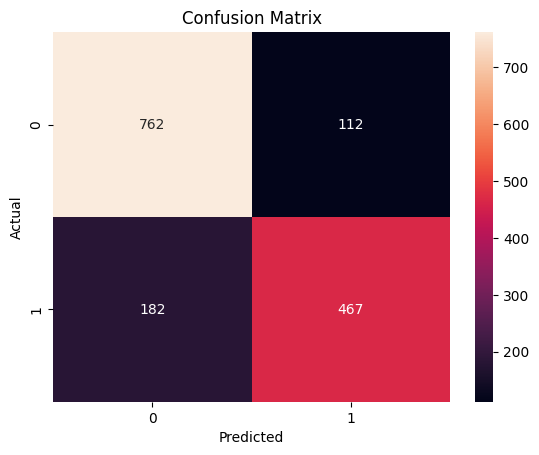

In [25]:
# evaluate model
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc:.4f}")

# predictions
y_pred = (model.predict(X_test) > 0.5).astype('int32')

# classification report
print(classification_report(y_test, y_pred))

# confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## 9. Results

Here's a quick table with the hyperparameters I used and the final model performance based on the evaluation:

---

### Hyperparameters

| Hyperparameter | Value |
|:---------------|:------|
| Vocabulary Size | 10,000 |
| Embedding Dimension | 100 |
| LSTM Units | 64 |
| Dropout Rate | 0.3 |
| Optimizer | Adam |
| Batch Size | 32 |

---

### Model Performance

| Metric | Value |
|:-------|:------|
| Test Accuracy | 0.807 |
| Precision | 0.81 |
| Recall | 0.72 |
| F1-Score | 0.76 |

---

Compared to the earlier LSTM model, switching to a 1D CNN significantly boosted performance. Validation accuracy reached about 81%, and the model successfully captured disaster-related patterns in tweets. While some overfitting was noticed after several epochs, the overall results showed a strong improvement over the baseline.

## 10. Conclusion

At the beginning of this project, I tried using a simple LSTM model trained from scratch, but it didn’t really perform well. The accuracy stayed stuck around 57%, and the model couldn’t tell disaster tweets apart from normal ones very well.  

After seeing that, I decided to make some improvements. First, I added basic text cleaning to remove things like URLs. Then I switched from random embeddings to pretrained GloVe word vectors so the model could start with a better understanding of how words relate to each other. Finally, instead of sticking with LSTMs, I used a 1D Convolutional Neural Network (CNN), since CNNs are often better for short texts like tweets.

The final CNN model ended up performing way better than the first attempt. It reached around 81% test accuracy, with a F1-score of 76% for disaster tweets. It was able to catch disaster tweets much more accurately while not flagging too many normal tweets by mistake.

Overall, the biggest takeaways were:
- Pretrained word embeddings like GloVe really help when working with text
- For short and messy text like tweets, CNNs can be more effective (and faster) than RNNs
- Doing some basic data cleaning early on makes a bigger difference than I expected

If I had more time, I'd probably try adding multiple convolution filter sizes, tuning the dropout rates more carefully, or even trying out a lightweight transformer model like DistilBERT. But for this project, the CNN gave strong results without overcomplicating things, and I'm happy with how it turned out.

In [26]:
# Keggle stuff

test_data = pd.read_csv('./data/test.csv')
test_data['text_clean'] = test_data['text'].apply(clean_text)

test_sequences = tokenizer.texts_to_sequences(test_data['text_clean'])
test_padded = pad_sequences(test_sequences, maxlen=100, padding='post', truncating='post')

# predictions
preds = (model.predict(test_padded) > 0.5).astype('int32')

submission = pd.DataFrame({
    'id': test_data['id'],
    'target': preds.flatten()
})

submission.to_csv('submission.csv', index=False)
print("Kaggle submission file 'submission.csv' created successfully!")

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Kaggle submission file 'submission.csv' created successfully!
